In [115]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.stats import linregress
from scipy.optimize import fsolve

In [116]:
N = 8
w0 = 0.2
w = 1.8
alpha = 0.1
h = 0.0001
wEE = 0
wEI = 0
wIE = 0
wII = 0
hE = h
hI = h

In [117]:
def get_W (N, w, w0, frac_inhib):
    NI = int(N*frac_inhib)
    NE = N - NI

    wE = ((w+w0)/2)
    wI = (wE-w0)

    wE = wE/NE
    wI = (-1)*wI/NI
    W = np.zeros((N, N))

    # Seleccionar aleatoriamente NI índices únicos para neuronas inhibitorias
    is_inhibitory = np.random.choice(N, NI, replace=False)

    # Las restantes serán neuronas excitatorias
    is_excitatory = np.setdiff1d(np.arange(N), is_inhibitory)

    for i in range(N):
        for j in range(N):
            if i!=j:
                if i in is_inhibitory:
                    W[i][j] = wI
                else:
                    W[i][j] = wE

    return W,is_excitatory, is_inhibitory, NE, NI

In [118]:
def f(x):
    return np.where(x > 0, np.tanh(x), 0)


# # Función de activación
# def f(s):
#     return np.tanh(s) * (s > 0)


In [119]:
# Derivadas deterministas
def dE_dt(E, I):
    sE = wEE * E - wEI * I + hE
    return -alpha * E + (1 - E) * f(sE)

def dI_dt(E, I):
    sI = wIE * E - wII * I + hI
    return -alpha * I + (1 - I) * f(sI)


In [120]:
def get_estado_inicial(Red, frac_active_NE=0.5, frac_active_NI=0.5, NE=0, NI=0, excit_indices= [], inhib_indices= []):

    NE_activos = int(frac_active_NE * NE)
    NI_activos = int(frac_active_NI * NI)

    # Convertir a listas para usar con random.sample
    inhib_indices = list(inhib_indices)
    excit_indices = list(excit_indices)
    
    # Seleccionar índices aleatorios sin reemplazo usando numpy
    inhib_seleccionados = np.random.choice(inhib_indices, size=NI_activos, replace=False)
    excit_seleccionados = np.random.choice(excit_indices, size=NE_activos, replace=False)

    indices_a_activar = np.concatenate([inhib_seleccionados, excit_seleccionados]).astype(np.int32)

    # Activar los elementos seleccionados
    Red[indices_a_activar] = 1

    return Red


In [121]:
def gillespie_algorithm(Red, W, T, log=0):
    tiempo_inicio = time.time()

    t = 0
    times = [t]
    rates = np.zeros(N)
    States = []
    Rates = []
    Spikes = []
    
    States.append(Red.copy())
    Rates.append(np.zeros(N))
    Spikes.append(np.zeros(N))

    step = 0
    while t <= T:
        spikes = np.zeros(N)
        #Calculamos los rates       
        r = 0
        for i in range(N):
            if Red[i] == 0: #=> La neurona está apagada f(s_i)
                suma = h
                for j in range(N):
                    suma += Red[j]*W[j][i]
                suma = f(suma)
                rates[i] = suma
                r += suma
            else: #=> La neurona está encendida tiene un CD de alpha segundos
                rates[i] = alpha
                r += alpha

        #Cuál debe ser el paso para que ocurra una "reacción"
        u1, u2 = np.random.uniform(0, 1, 2)
        
        dt = (1/r)*np.log(1/u1)
        #Qué neurona es la que sufre esa reacción?
        suma = 0
        i = 0
        sigo = True
        while i < N and sigo:
            suma += rates[i] / r
            if u2 <= suma:
                neurona = i
                sigo = False
            else:
                i += 1
        
        #Cambio el estado de dicha neurona
        if Red[neurona] == 0:
            Red[neurona] = 1
            spikes[neurona] = 1
        elif Red[neurona] == 1:
            Red[neurona] = 0

        #Avanzo el tiempo
        t += dt
        if log > 0:
            if (step % log == 0): 
                tiempo_actual = time.time()
                tiempo_transcurrido = tiempo_actual - tiempo_inicio
                print(
                    f"\rSe han realizado {step} pasos | t={t:.3f}s ({t/T*100:.2f}%) | "
                    f"Tiempo transcurrido: {tiempo_transcurrido:.2f}s | ETA: {tiempo_transcurrido/(t/T):.2f}s",
                    end="",
                    flush=True
                )


        step += 1
        States.append(Red.copy())
        Rates.append(rates.copy())
        Spikes.append(spikes.copy())
        times.append(t)

    
    print()
    return np.array(States), np.array(Rates), np.array(Spikes), np.array(times)


In [122]:
def get_ISI(times, Spikes):
    times = np.array(times)
    Spikes = np.array(Spikes)  # Asegúrate de que es un array NumPy
    
    # Si Spikes es 2D (n_steps x n_neurons), busca cualquier spike por fila
    if Spikes.ndim == 2:
        mask = np.any(Spikes > 0, axis=1)
    else:  # Si es 1D
        mask = Spikes > 0

    spike_times = times[mask]
    isis = np.diff(spike_times)
    
    if len(isis) == 0:
        return None  # o np.nan o lanzar un error
    return np.mean(isis)



In [123]:
def get_avalanche_distribution(times, Spikes):
    times = np.array(times)
    Spikes = np.array(Spikes)
    
    # 1. Detectar tiempos de spike
    if Spikes.ndim == 2:
        mask = np.any(Spikes > 0, axis=1)
    else:
        mask = Spikes > 0

    spike_times = times[mask]
    
    # Si no hay spikes suficientes, devolver lista vacía
    if len(spike_times) < 2:
        return []

    # 2. Calcular ISI promedio
    isi_avg = np.mean(np.diff(spike_times))
    
    # 3. Binarizar el tiempo en bins de tamaño ISI_avg
    t_min, t_max = times[0], times[-1]
    bins = np.arange(t_min, t_max + isi_avg, isi_avg)
    binned_counts, _ = np.histogram(spike_times, bins=bins)

    # 4. Detectar avalanchas: secuencias de bins con spikes (>0) separados por 0s
    avalanches = []
    size = 0
    for count in binned_counts:
        if count > 0:
            size += count
        elif size > 0:
            avalanches.append(size)
            size = 0
    # Si termina con una avalancha activa
    if size > 0:
        avalanches.append(size)

    return avalanches


In [124]:
def analyze_avalanche_distribution(times, Spikes):
    avalanches = get_avalanche_distribution(times, Spikes)

    if len(avalanches) == 0:
        print("No se detectaron avalanchas.")
        return

    # Histograma logarítmico
    bins = np.logspace(np.log10(1), np.log10(max(avalanches)+1), num=20)
    counts, edges = np.histogram(avalanches, bins=bins, density=True)

    bin_centers = (edges[:-1] + edges[1:]) / 2

    mask = counts > 0
    x = bin_centers[mask]
    y = counts[mask]
    y = y / np.sum(y)

    # Ajuste lineal en escala log-log
    log_x = np.log10(x)
    log_y = np.log10(y)
    slope, intercept, r_value, p_value, std_err = linregress(log_x, log_y)

    alpha = -slope  # ley de potencias: P(x) ~ x^(-alpha)

    # Graficar
    plt.figure(figsize=(6, 4))
    plt.scatter(x, y, color='black', label='Datos')
    plt.plot(x, 10**(intercept + slope * np.log10(x)), label=f'Ajuste (α ≈ {alpha:.2f})', linestyle='--')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Tamaño de avalancha')
    plt.ylabel('Densidad de probabilidad')
    plt.title('Distribución de tamaño de avalanchas')
    plt.grid(True, which='both', ls='--', linewidth=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"Ajuste ley de potencias (estimación log-log): alpha ≈ {alpha:.2f}")
    print(f"R² del ajuste: {r_value**2:.3f}")


In [125]:
#Parámetros del sistema
N = 200
frac_inhib = 0.5
w = 13.8
w0 = 0.2

W, excit_indices, inhib_indices, NE, NI = get_W(N, w, w0, frac_inhib=frac_inhib)
Red = get_estado_inicial(np.zeros(N), frac_active_NE=0.5, frac_active_NI=0, NE=NE, NI=NI, inhib_indices=inhib_indices, excit_indices=excit_indices)

#Parámetros de la simulación
T = 1000

alpha = 0.1
h = 0.001

States, Rates, Spikes, times= gillespie_algorithm(Red, W, T, log=1000)

Se han realizado 8000 pasos | t=954.192s (95.42%) | Tiempo transcurrido: 101.18s | ETA: 106.04s


In [135]:
all_indices = np.arange(N)
inhib_indices = np.array(inhib_indices)
excit_indices = np.setdiff1d(all_indices, inhib_indices)

# Reordenamos usando bucles
States_ordered = []
Spikes_ordered = []
Rates_ordered = []

for t in range(len(States)):
    s_ordered = np.concatenate([States[t][inhib_indices], States[t][excit_indices]])
    sp_ordered = np.concatenate([Spikes[t][inhib_indices], Spikes[t][excit_indices]])
    r_ordered = np.concatenate([Rates[t][inhib_indices], Rates[t][excit_indices]])
    
    States_ordered.append(s_ordered)
    Spikes_ordered.append(sp_ordered)
    Rates_ordered.append(r_ordered)

# Convertimos a arrays para graficar
States_ordered = np.array(States_ordered)
Spikes_ordered = np.array(Spikes_ordered)
Rates_ordered = np.array(Rates_ordered)


mean_firing = np.mean(Rates, axis=1)
std_firing = np.std(Rates, axis=1)

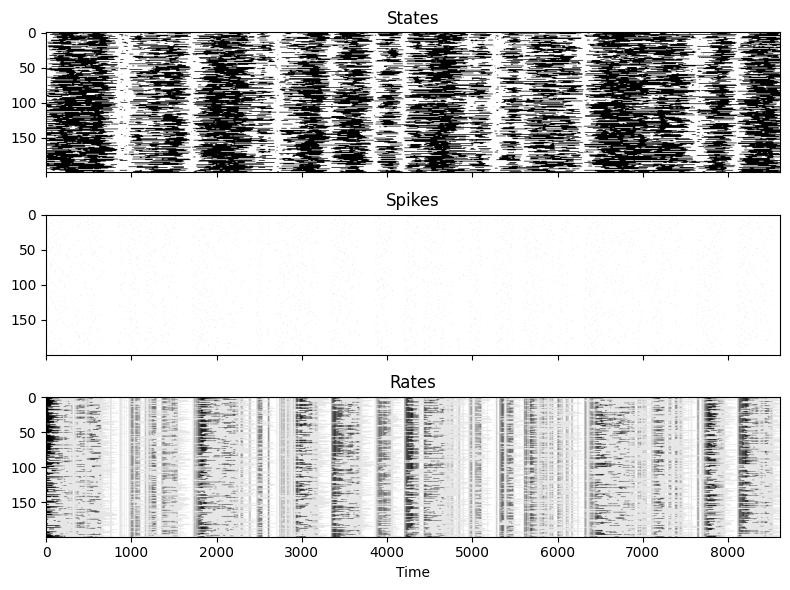

In [136]:
# Dibujamos las 3 matrices una debajo de otra
fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

axes[0].imshow(np.transpose(States_ordered), cmap='gray_r', aspect='auto')
axes[0].set_title("States")

axes[1].imshow(np.transpose(Spikes_ordered), cmap='gray_r', aspect='auto')
axes[1].set_title("Spikes")

axes[2].imshow(np.transpose(Rates_ordered), cmap='gray_r', aspect='auto')
axes[2].set_title("Rates")
axes[2].set_xlabel("Time")

plt.tight_layout()
plt.show()

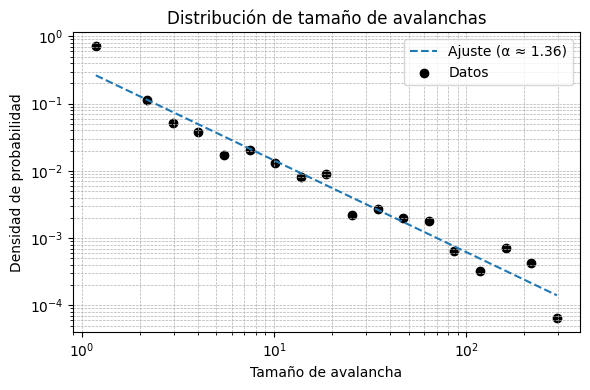

Ajuste ley de potencias (estimación log-log): alpha ≈ 1.36
R² del ajuste: 0.953


In [137]:
analyze_avalanche_distribution(times, Spikes)

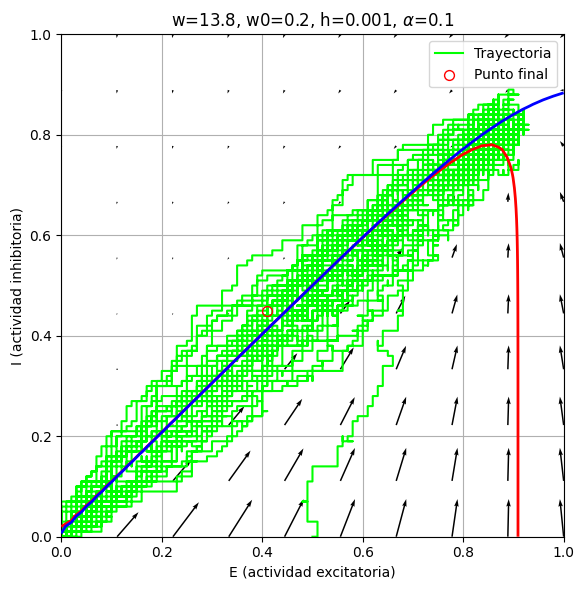

In [138]:
#Evolución del sistema
NI_evol = []
NE_evol = []

for step in States:
    NI_active = sum(step[inhib_indices])
    NE_active = sum(step[excit_indices])
    NI_evol.append(NI_active/NI)
    NE_evol.append(NE_active/NE)

# Parámetros del modelo
WE = (w+w0)/2
WI = WE-w0
wEE = WE
wEI = WI
wIE = WE
wII = WI
hE = h
hI = h

#Campo vectorial y las nulclinas
E_field_vals = np.linspace(0, 1, 10)
I_field_vals = np.linspace(0, 1, 10)
E_field, I_field = np.meshgrid(E_field_vals, I_field_vals)

dE = dE_dt(E_field, I_field)
dI = dI_dt(E_field, I_field)

# Normalizar vectores
magnitude = np.sqrt(dE**2 + dI**2)
dE_norm = dE*3
dI_norm = dI*3

E_contour_vals = np.linspace(0, 1, 50)
I_contour_vals = np.linspace(0, 1, 50)
E_contour, I_contour = np.meshgrid(E_contour_vals, I_contour_vals)

dE_contour = dE_dt(E_contour, I_contour)
dI_contour = dI_dt(E_contour, I_contour)

plt.figure(figsize=(7, 6))

# Campo vectorial
plt.quiver(E_field, I_field, dE_norm, dI_norm, color='black', alpha=1, width=0.003, scale=40)

# Nullclines
cs1 = plt.contour(E_contour, I_contour, dE_contour, levels=[0], colors='red', linewidths=2, zorder=20)
cs2 = plt.contour(E_contour, I_contour, dI_contour, levels=[0], colors='blue', linewidths=2, zorder=20)
# plt.clabel(cs1, fmt={'0': '$dE/dt=0$'}, colors='red')
# plt.clabel(cs2, fmt={'0': '$dI/dt=0$'}, colors='blue')

# # Punto fijo
# plt.scatter(
#     E_fp, 
#     I_fp, 
#     facecolor=(1, 1, 1, 0), 
#     edgecolors=(0, 0, 0), 
#     label='Punto fijo',
#     s=50,
#     zorder=15)

plt.plot(NE_evol, NI_evol, color=(0, 1, 0), label='Trayectoria')
plt.scatter(
    NE_evol[-1], 
    NI_evol[-1],
    facecolor=(1, 1, 1, 0), 
    edgecolors=(1, 0, 0), 
    label='Punto final',
    s=50,
    zorder=10)

plt.xlabel("E (actividad excitatoria)")
plt.ylabel("I (actividad inhibitoria)")
plt.title(fr"w={w}, w0={w0}, h={h}, $\alpha$={alpha}")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


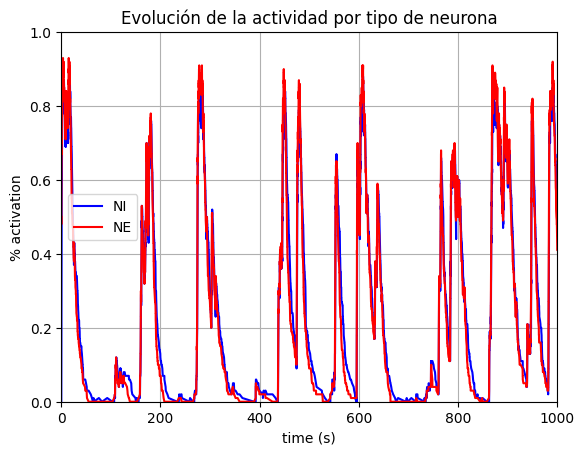

In [139]:
plt.plot(times, NI_evol, label="NI", color="blue")
plt.plot(times, NE_evol, label="NE", color="red")
plt.xlabel("time (s)")
plt.grid()
plt.ylabel("% activation")
plt.ylim(0, 1)
plt.xlim(0, T)
plt.title("Evolución de la actividad por tipo de neurona")
plt.legend()

In [140]:
def get_branching_data(times, Spikes):
    times = np.array(times)
    Spikes = np.array(Spikes)

    if Spikes.ndim != 2:
        raise ValueError("Spikes debe ser un array 2D (tiempo x canales)")

    # 1. Detectar actividad
    active = np.any(Spikes > 0, axis=1)
    spike_times = times[active]

    if len(spike_times) < 2:
        return [], []

    isi_avg = np.mean(np.diff(spike_times))

    # 2. Binarizar en bins temporales
    t_min, t_max = times[0], times[-1]
    bins = np.arange(t_min, t_max + isi_avg, isi_avg)
    digitized = np.digitize(times, bins) - 1

    # 3. Contar cuántos electrodos activos hay por bin temporal
    binned_activity = np.zeros((len(bins)-1, Spikes.shape[1]), dtype=int)
    for i in range(len(times)):
        if 0 <= digitized[i] < len(binned_activity):
            binned_activity[digitized[i]] |= (Spikes[i] > 0)

    binned_counts = np.sum(binned_activity, axis=1)

    # 4. Detectar avalanchas y recolectar na y nd
    na_list = []
    nd_list = []
    i = 0
    while i < len(binned_counts) - 1:
        if binned_counts[i] > 0:
            na = binned_counts[i]
            nd = binned_counts[i + 1]
            na_list.append(na)
            nd_list.append(nd)
            # avanzar hasta terminar avalancha
            while i < len(binned_counts) and binned_counts[i] > 0:
                i += 1
        else:
            i += 1

    return na_list, nd_list


In [141]:
import numpy as np

def compute_branching_parameter(ancestor_counts, descendant_counts, nmax):
    """
    Computes the branching parameter sigma following Beggs & Plenz (2003).
    
    Parameters:
    - ancestor_counts: list or array of number of active electrodes in the first bin (na)
    - descendant_counts: list or array of number of active electrodes in the second bin (nd)
    - nmax: maximum number of electrodes
    
    Returns:
    - sigma: estimated branching parameter
    """
    assert len(ancestor_counts) == len(descendant_counts), "Input lists must be the same length."
    
    p_d = {}
    total_ancestors = 0
    
    for na, nd in zip(ancestor_counts, descendant_counts):
        if na == 0:
            continue
        d = round(nd / na)
        key = d
        correction_factor = (nmax - 1) / (nmax - na) if (nmax - na) != 0 else 0
        if key in p_d:
            p_d[key]['na_sum'] += na * correction_factor
            p_d[key]['count'] += 1
        else:
            p_d[key] = {'na_sum': na * correction_factor, 'count': 1}
        total_ancestors += na

    sigma = sum([d * (entry['na_sum'] / total_ancestors) for d, entry in p_d.items()])
    return sigma

# Example usage (needs actual data to produce meaningful result)
# compute_branching_parameter([1, 1, 2, 3], [2, 1, 3, 6], 60)



In [142]:
na, nd = get_branching_data(times, Spikes)
sigma = compute_branching_parameter(na, nd, nmax=Spikes.shape[1])
print(f"Parámetro de branching estimado: σ ≈ {sigma:.3f}")


Parámetro de branching estimado: σ ≈ 1.126


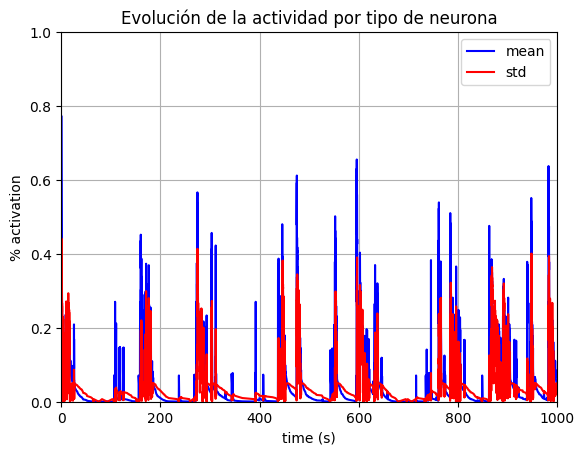

In [143]:
plt.plot(times, mean_firing, label="mean", color="blue")
plt.plot(times, std_firing, label="std", color="red")
plt.xlabel("time (s)")
plt.grid()
plt.ylabel("% activation")
plt.ylim(0, 1)
plt.xlim(0, T)
plt.title("Evolución de la actividad por tipo de neurona")
plt.legend()